In [1]:
%load_ext notexbook
%texify

# Reproducible Data Pipelines in PyTorch

In this tutorial we will walk together throught various _bits and bobs_ of **Data Pipelines** for your Machine/Deep learning experiments, using the **PyTorch** framework.

Before we get to that though, let's try to answer a few preliminary questions:

- What is _data_ for Machine/Deep learning  ? 
- What is _data pipelines_ for Machine/Deep learning ?
- What does it mean _reproducible_

### 1. What is _data_ for ML ?

To clarify the concept of **data** for machine learning, let's immediately introduce the **data case** we are going to use throughout the whole tutorial.


#### It's time for some Magic

<img src="https://m.media-amazon.com/images/I/61AGZ37D7eL.jpg" alt="MTG Card back" class="maxw30" /> 

**Anatomy of a Magic: The Gathering** (`MTG`) card

<img src="https://hips.hearstapps.com/hmg-prod/images/shivan-dragon-1-1550174439.jpg" alt="Anatomy of MTG card" class="maxw40" />

**Classic** (a.k.a. OldSchool) Magic vs **Modern** Magic

<img alt="Shivan Dragon M19" src="https://cards.scryfall.io/png/front/d/3/d389b8db-5866-4146-a379-f24b6463622b.png?1562304398" class="maxw20" />

<img alt="Shivan Dragon Alpha" src="https://cards.scryfall.io/png/front/f/e/fefbf149-f988-4f8b-9f53-56f5878116a6.png?1559591401" class="maxw20" />

#### Data Representation for Machine Learning

_(With very few exceptions)_

In Machine learning data is assumed to be represented by a Matrix of size `[n_samples, n_features]`, namely the **feature matrix**:

$$
{\rm feature~matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
x_{11} & x_{12} & \cdots & x_{1D}\\
x_{21} & x_{22} & \cdots & x_{2D}\\
x_{31} & x_{32} & \cdots & x_{3D}\\
\vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{ND}\\
\end{matrix}
\right]
$$

Moreover, in the case of _Supervised learning_ settings, there is also the **label** vector, of size `n_samples`, containing the list of labels for each samples.

$$
{\rm label~vector:~~~} {\bf y}~=~ [y_1, y_2, y_3, \cdots y_N]
$$

In this notation, we are indicating with $N$ the number of samples, and $D$ the number of features.

- $N$ (`n_samples`): each sample is an item to process (e.g. to classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
  
- $D$ (`n_features`): features or (*traits*, or *observations*) represent the information that can be used to describe each item in a **quantitative**[$^3$](#fn3) manner. In fact, features are generally **real-valued**, but may also be boolean, **discrete-valued** or any combination of those.

The number of **features** _must_ be fixed in advance.

Each sample (data point) is a row in the feature data array, and each feature **may be** a column 
(if features can be expressed by `1D vector`). 

Features can be also be very high dimensional (e.g. millions of features), but sometimes also very sparse. This is a case where `scipy.sparse` matrices (and `torch.sparse`) [tensors](https://pytorch.org/docs/stable/sparse.html?highlight=torch%20sparse) can be very useful. 

These structures are much more memory-efficient than **dense** `numpy` arrays.

<span id="fn3"><i>[3]</i> Emphasis on **quantitative** here!</span>

<a name="feat-to-numbers"></a>

##### Features $\mapsto$ Numbers

Therefore, it is important to keep in mind that **features** must be _ultimately_ **numbers** in order to be processed by a Machine Learning model.

This applies to any format the initial `raw data` may have (e.g. *textual*, *tabular*, *images*); but this sometimes does not even require any further **transformations**[$^4$](#fn4).

<span id="fn4"><i>[4]: </i>Please bear in mind this word when we will later introduce the concept of samples _transformations_ and _transformers_ </span>

<a name="image-example"></a>
##### Example: Image Data

Let's consider the image of this cute little dragon 🐲, for example: 

![🐶](https://cards.scryfall.io/normal/front/f/e/fefbf149-f988-4f8b-9f53-56f5878116a6.jpg)

<span class="fn"><i>Source: </i> [https://cards.scryfall.io/png/front/f/e/fefbf149-f988-4f8b-9f53-56f5878116a6.png?1559591401)</span>

This image can be indeed represented as a `3D array`: (`channel`, `width`, `height`). In particular this image has `3` channels, namely **R**ed, **G**reen, **B**lue, in the so-called [`RGB`](https://en.wikipedia.org/wiki/RGB_color_model) colour model.

For each channel $C$, every element (i.e. `pixel`) of their $W \times H$ matrix correspond to an intensity value.

<img src="https://e2eml.school/images/image_processing/three_d_array.png" class="maxw40" />

<span class="fn"><i>Source: </i> [https://e2eml.school/images/image_processing/three_d_array.png](https://e2eml.school/images/image_processing/three_d_array.png)</span>

If we now should think of a particular data structure to represent this data, there are so many clues that lead immediately to **NumPy** and `ndarray`: **(1)** contiguous memory with **(2)** fixed-size (i.e. $C \times W \times H$), and **(3)** homogeneous content (i.e. `uint8` or `float`).
This is **no surprise**, and `ndarray` is indeed the main <ins>reference data structure</ins> [expected](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#loading-an-example-dataset) by ML models in `scikit-learn`.

Let's now read this image using `matplotlib` ([`imread`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imread.html)), and see what do we get.

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import requests 
from PIL import Image
from io import BytesIO

In [11]:
img_url = "https://cards.scryfall.io/normal/front/f/e/fefbf149-f988-4f8b-9f53-56f5878116a6.jpg"
response = requests.get(img_url)
image = np.asarray(Image.open(BytesIO(response.content), "r"))
print(f"Image Type: {type(image)}")

Image Type: <class 'numpy.ndarray'>


In [12]:
print("Image shape: (W:{} x H:{} x C:{})".format(*image.shape))

Image shape: (W:680 x H:488 x C:3)


**Note**: 
In `numpy`, the channel is storead as to the *last* dimension ($W \times H \times C$); whereas in `torch` the channel is expected to be the *first* dimension ($C \times W \times H$).


Let's show `image` using `matplotlib.imshow`...

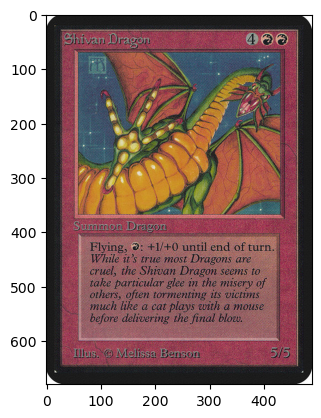

In [13]:
plt.imshow(image)
plt.show()

... and let's also have a look at the actual content of the array

In [14]:
image[:10, :5, 0]  # (with some slicing, for readability)

array([[255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255],
       [253, 255, 246, 255, 255],
       [255, 246, 255, 251, 246]], dtype=uint8)

Let's show the same image per single channel

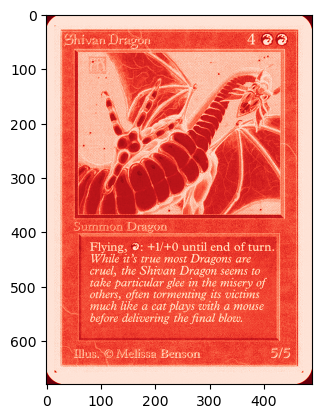

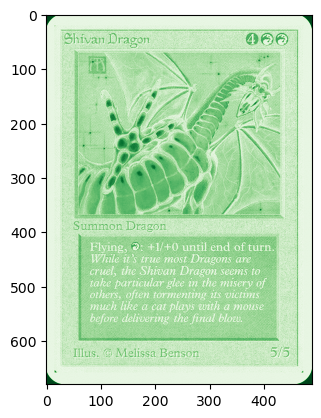

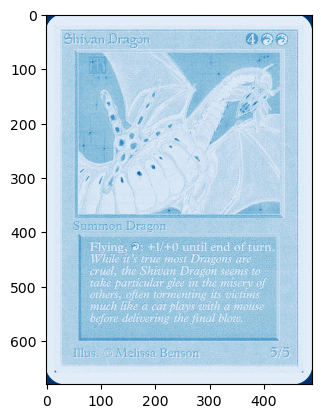

In [15]:
R, G, B = image[..., 0], image[...,1], image[..., 2]
cmaps = ("Reds", "Greens", "Blues")
for channel, colour_map in zip((R, G, B), cmaps):
    plt.imshow(channel, cmap=colour_map)
    plt.show()

... and then back into RGB with the three channels combined as a double check:

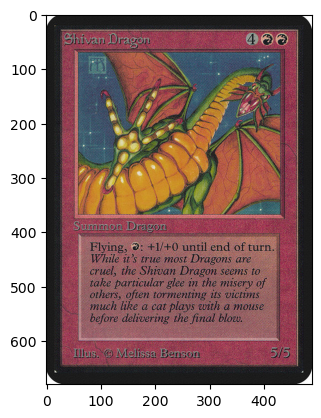

In [16]:
rgb_stack = (np.dstack((R,G,B))).astype(np.uint8)
plt.imshow(rgb_stack)
plt.show()

💡

If now you are thinking something like: 

>(**A.**)"*Hang on, how this matches with the Data Representation model introduced before?* 🤔 
> _You just demonstrated that image pixels are indeed numbers, and so potentially being used as `features` [$^{note}$](#note). However, you also said that Images are `3D-array` objects, so (**B.**) how does having **multiple** ($>2$) dimensions fit with that Representation model?_ 
> (**C.**) _Is this any *special* case or exception to the model?_" 

If that resembles _more or less_ what you are really thinking right now, well...**congrats indeed!!**

The answer to this question will be given in details in the [last](#efficient-numpy) section of this notebook. Short answer for now is: "_No, Images are **no** special case. The model still complies!_"

<span id="note" class="fn"><i>[Note]: </i> This is exactly what it is, especially in the Deep Learning case! </span>

### 2. What is _data pipeline_ for ML ?

First and foremost: the **learning process** is itself a pipeline!

(**Note**: we will detail all the components of this pipeline in the next chapter!)

<img alt="the learning process" src="https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/2_torch_dataset/learning_process.png" class="maxw80" />

**however...** there is more (in _real life ml_)

<img src="https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/1_prelude/imgs/ml_full_picture.png" class="maxw90" alt="overall_ds_pipeline" />

### 3. What do we mean by _reproducible data pipeline_ ?

A **robust** and controlled **Model Evaluation** pipeline (a.k.a. **Machine Learning Experiment**) is the first key to reproducibility.
<br/><br/>

<img src="https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_validation_test2.svg" alt="train-valid-test ml pipeline" class="maxw80" />

however the pipeline could get more complicated (as in case of `Repeated Cross Validation`

<br/><br/>

<img src="https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/cross_validation.svg" alt="cv ml pipeline" class="maxw80" />

In these cases, you want to make sure that all data are processed correctly with no **selection bias** and no inflation in data partitions!

**LAST BUT NOT LEAST**, Reproducible also means **repeatable**. There is a lot of _randomness_ in ML pipelines (models, parameters, optimisers, data selections). 

You **want** to make sure you can control all the possible pseudo-randomness in your pipeline! 